In [1]:
import os
import re
import sys
import glob
import time
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
import scipy

import peakutils

from datetime import datetime

import math
from scipy          import stats
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import matplotlib

# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.rcParams["figure.figsize"] = 7.5, 4.5
plt.rcParams["font.size"]      = 12

In [6]:
fav_col = '#418094'

In [7]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/'

thr_ADC        = 80
sg_filt_window = 30
min_dist       = 50

def extract_date_obj_and_number(filename):
    match       = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    date_str    = match.group(1)
    file_number = int(match.group(2))
    date_obj    = datetime.strptime(date_str, "%m_%d_%Y")
    return date_obj, file_number

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

def adapt_evt_id(evt_id, fnum):
    return 1000000*fnum + np.array(evt_id)

In [8]:
### Gains to calibrate the channels
## With the trigger channels it depends on the date because there were more variations

gains_all_chs = {0: (142.951, 5.925),
                 1: (132.500, -3.333),
                 2: (135.502, 12.886),
                 3: (135.000, -5.000),
                 4: (143.315,  5.262),
                 5: (137.660, 11.814),
                 6: (130.000, 0.),
                 7: (138.123, 12.840),
                 8: (131.772, 13.920),
                 9: {'09_10_2024': (713.445, -20.038), 
                     '09_11_2024': (716.176, -19.673), 
                     '09_12_2024': (719.783, -10.151), 
                     '09_20_2024': (722.221, -11.124), 
                     '09_25_2024': (723.042, -11.830), 
                     '09_28_2024': (721.611, -12.276), 
                     '10_04_2024': (720.181, -12.722), 
                     '10_11_2024': (725.152, -12.032), 
                     '10_17_2024': (728.640, -11.851), 
                     '10_25_2024': (722.907, -12.550), 
                     '11_01_2024': (724.566, -11.215), 
                     '11_11_2024': (714.408, -12.857), 
                     '11_25_2024': (704.251, -14.499), 
                     '12_13_2024': (691.857,   2.794), 
                     '12_21_2024': (680.420,  -3.534), 
                     '01_02_2025': (671.088,   4.511), 
                     '01_10_2025': (703.052,   0.083), 
                     '01_19_2025': (707.833,  -5.059)},
                 
                 10: {'09_10_2024': (707.800, 43.580), 
                      '09_11_2024': (707.968, 44.407), 
                      '09_12_2024': (706.610, 45.092), 
                      '09_20_2024': (703.655, 53.165), 
                      '09_25_2024': (703.754, 53.722), 
                      '09_28_2024': (704.139, 52.949), 
                      '10_04_2024': (705.643, 52.823), 
                      '10_11_2024': (706.706, 53.208), 
                      '10_17_2024': (707.740, 53.039), 
                      '10_25_2024': (707.276, 53.987), 
                      '11_01_2024': (705.825, 54.078), 
                      '11_11_2024': (705.377, 53.354), 
                      '11_25_2024': (705.761, 52.763), 
                      '12_13_2024': (709.026, 53.851), 
                      '12_21_2024': (709.094, 55.053), 
                      '01_02_2025': (709.721, 55.118), 
                      '01_10_2025': (710.348, 55.183), 
                      '01_19_2025': (711.481, 54.422)},
                 
                 11: {'09_10_2024': (641.030, 48.974), 
                      '09_11_2024': (642.714, 47.617), 
                      '09_12_2024': (645.527, 48.325), 
                      '09_20_2024': (648.580, 45.411), 
                      '09_25_2024': (651.633, 42.497), 
                      '09_28_2024': (651.651, 42.437), 
                      '10_04_2024': (652.104, 42.815), 
                      '10_11_2024': (652.307, 42.757), 
                      '10_17_2024': (652.510, 42.698), 
                      '10_25_2024': (641.258, 60.174), 
                      '11_01_2024': (647.961, 51.403), 
                      '11_11_2024': (654.665, 42.632), 
                      '11_25_2024': (656.109, 43.477), 
                      '12_13_2024': (656.052, 44.115), 
                      '12_21_2024': (655.995, 44.754), 
                      '01_02_2025': (655.938, 45.393), 
                      '01_10_2025': (655.881, 46.032), 
                      '01_19_2025': (656.365, 44.774)}}

In [9]:
def get_ch_info(min_dist, cal=None, month=None, nfiles=10000, ch=8):
    if min_dist==50:
        if month:
            filt_files = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_run-{month}*')
        else:
            filt_files = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_run-*')
    else:
        if month:
            filt_files = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_ch{ch}_run-{month}*')
        else:
            filt_files = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_ch{ch}_run-*')
    sorted_files = sorted(filt_files, key=extract_date_obj_and_number)
    
    start_time = time.time()
    
    idx_max   = {}
    idx_thr   = {}
    height_sg = {}
    if ch<9:
        filt_evts = {}
        
        print(len(sorted_files))
        for ifile,filename in enumerate(sorted_files[:nfiles]):
            if ifile%20==0:
                print(ifile)
            d          = np.load(filename, allow_pickle=True)
            date, fnum = extract_date_and_number(filename)
        
            if date not in idx_max:
                print(date)
                filt_evts[date] = d['filt_evts_dict'].item()[ch]
                idx_max  [date] = d['idx_peaks_max'] .item()[ch]
                idx_thr  [date] = d['idx_peaks_thr'] .item()[ch]
                if cal:
                    height_sg[date] = (d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0]
                else:
                    height_sg[date] = d['height_peaks_sg'].item()[ch]
            else:
                for ch in [8]:
                    try:
                        filt_evts[date] = np.concatenate((filt_evts[date], adapt_evt_id(d['filt_evts_dict'].item()[ch], fnum)))
                        idx_max  [date] = np.concatenate((idx_max  [date], d['idx_peaks_max'].item()[ch]))
                        idx_thr  [date] = np.concatenate((idx_thr  [date], d['idx_peaks_thr'].item()[ch]))
                        if cal:
                            height_sg[date] = np.concatenate((height_sg[date], (d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0]))
                        else:
                            height_sg[date] = np.concatenate((height_sg[date], d['height_peaks_sg'].item()[ch]))
                    except Exception as e:
                        print(date, fnum, filename, ch, str(e))
                        continue
        return filt_evts, idx_max, idx_thr, height_sg
                        
    else:
        print(len(sorted_files))
        for ifile,filename in enumerate(sorted_files[:nfiles]):
            if ifile%20==0:
                print(ifile)
            d          = np.load(filename, allow_pickle=True)
            date, fnum = extract_date_and_number(filename)
        
            if date not in idx_max:
                print(date)
                idx_max[date] = d['idx_peaks_max_trigg'].item()[ch]
                idx_thr[date] = d['idx_peaks_thr_trigg'].item()[ch]
                if cal:
                    height_sg[date] = (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0]
                else:
                    height_sg[date] = d['height_peaks_sg_trigg'].item()[ch]
            else:
                for ch in [ch]:
                    try:
                        idx_max[date] = np.concatenate((idx_max[date], d['idx_peaks_max_trigg']  .item()[ch]))
                        idx_thr[date] = np.concatenate((idx_thr[date], d['idx_peaks_thr_trigg']  .item()[ch]))
                        if cal:
                            height_sg[date] = np.concatenate((height_sg[date], (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0]))
                        else:
                            height_sg[date] = np.concatenate((height_sg[date], d['height_peaks_sg_trigg'].item()[ch]))
                    except Exception as e:
                        print(date, fnum, filename, ch, str(e))
                        continue
                    
    end_time     = time.time()                
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")
    return idx_max, idx_thr, height_sg


def get_t_dist_from_hit_map(timestamps, amplitudes, bin_size=None):
    #bin_size is in time samples. bins_size=20 would be 40 ns
    unique_tmstmp = np.unique(timestamps)
    sum_ampl      = np.array([np.sum(amplitudes[timestamps == timestamp]) for timestamp in unique_tmstmp])
    if bin_size:
        reshaped = sum_ampl[:len(sum_ampl) - len(sum_ampl) % bin_size].reshape(-1, bin_size)
        sum_ampl   = reshaped.sum(axis=1)
        return bin_size*np.arange(len(sum_ampl)), sum_ampl
    else:
        return unique_tmstmp, sum_ampl

In [101]:
filt_evts_ch8_10,  idx_max_ch8_10,  idx_thr_ch8_10,  height_sg_ch8_10  = get_ch_info( 5, ch=8)
filt_evts_ch8_20,  idx_max_ch8_20,  idx_thr_ch8_20,  height_sg_ch8_20  = get_ch_info(10, ch=8)
filt_evts_ch8_30,  idx_max_ch8_30,  idx_thr_ch8_30,  height_sg_ch8_30  = get_ch_info(15, ch=8)
filt_evts_ch8_50,  idx_max_ch8_50,  idx_thr_ch8_50,  height_sg_ch8_50  = get_ch_info(25, ch=8)
filt_evts_ch8_100, idx_max_ch8_100, idx_thr_ch8_100, height_sg_ch8_100 = get_ch_info(50, ch=8)

1383
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
580
600
620
640
11_01_2024
660
680
700
720
11_11_2024
740
760
780
800
820
11_25_2024
840
860
880
900
920
12_13_2024
940
960
980
1000
1020
12_21_2024
1040
1060
1080
1100
1120
01_02_2025
1140
1160
1180
1200
01_10_2025
1220
1240
1260
1280
01_19_2025
1300
1320
1340
1360
1380
1383
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
580
600
620
640
11_01_2024
660
680
700
720
11_11_2024
740
760
780
800
820
11_25_2024
840
860
880
900
920
12_13_2024
940
960
980
1000
1020
12_21_2024
1040
1060
1080
1100
1120
01_02_2025
1140
1160
1180
1200
01_10_2025
1220
1240
1260
1280
01_19_2025
1300
1320
1340
1360
1380
1383
0

In [11]:
uniq_ts_10_max, sum_ampls_10_max   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_10   [date]) for date in idx_max_ch8_10   .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_10 [date]) for date in height_sg_ch8_10 .keys()]))
uniq_ts_10_thr, sum_ampls_10_thr   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_10   [date]) for date in idx_thr_ch8_10   .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_10 [date]) for date in height_sg_ch8_10 .keys()]))
uniq_ts_20_max, sum_ampls_20_max   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20   [date]) for date in idx_max_ch8_20   .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_20 [date]) for date in height_sg_ch8_20 .keys()]))
uniq_ts_20_thr, sum_ampls_20_thr   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_20   [date]) for date in idx_thr_ch8_20   .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_20 [date]) for date in height_sg_ch8_20 .keys()]))
uniq_ts_30_max, sum_ampls_30_max   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_30   [date]) for date in idx_max_ch8_30   .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_30 [date]) for date in height_sg_ch8_30 .keys()]))
uniq_ts_30_thr, sum_ampls_30_thr   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_30   [date]) for date in idx_thr_ch8_30   .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_30 [date]) for date in height_sg_ch8_30 .keys()]))
uniq_ts_50_max, sum_ampls_50_max   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_50   [date]) for date in idx_max_ch8_50   .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_50 [date]) for date in height_sg_ch8_50 .keys()]))
uniq_ts_50_thr, sum_ampls_50_thr   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_50   [date]) for date in idx_thr_ch8_50   .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_50 [date]) for date in height_sg_ch8_50 .keys()]))
uniq_ts_100_max, sum_ampls_100_max = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_100  [date]) for date in idx_max_ch8_100  .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_100[date]) for date in height_sg_ch8_100.keys()]))
uniq_ts_100_thr, sum_ampls_100_thr = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_100  [date]) for date in idx_thr_ch8_100  .keys()]),
                                                               np.concatenate([np.concatenate(height_sg_ch8_100[date]) for date in height_sg_ch8_100.keys()]))

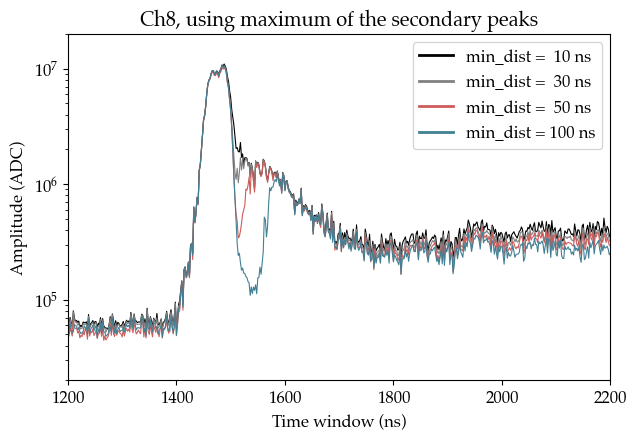

In [217]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_10_max,  sum_ampls_10_max,  lw=0.8, c='k',         label=f'min_dist =  10 ns')
#plt.plot(uniq_ts_20_max,  sum_ampls_20_max,  lw=0.8, c='orange',    label=f'min_dist =  20 ns')
plt.plot(uniq_ts_30_max,  sum_ampls_30_max,  lw=0.8, c='grey',      label=f'min_dist =  30 ns')
plt.plot(uniq_ts_50_max,  sum_ampls_50_max,  lw=0.8, c='indianred', label=f'min_dist =  50 ns')
plt.plot(uniq_ts_100_max, sum_ampls_100_max, lw=0.8, c=fav_col,     label=f'min_dist = 100 ns')
plt.title('Ch8, using maximum of the secondary peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1200, 2200)
plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

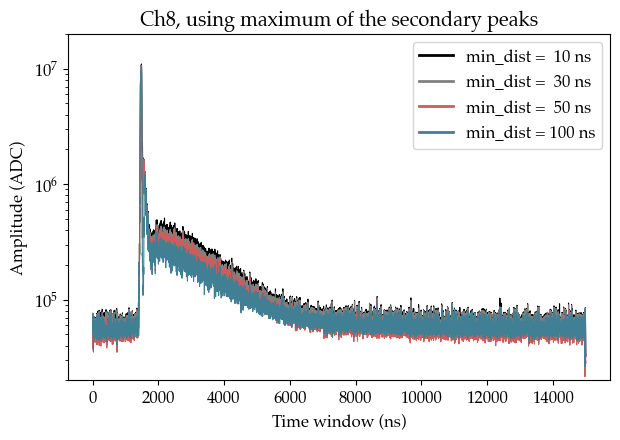

In [218]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_10_max,  sum_ampls_10_max,  lw=0.8, c='k',         label=f'min_dist =  10 ns')
#plt.plot(uniq_ts_20_max,  sum_ampls_20_max,  lw=0.8, c='orange',    label=f'min_dist =  20 ns')
plt.plot(uniq_ts_30_max,  sum_ampls_30_max,  lw=0.8, c='grey',      label=f'min_dist =  30 ns')
plt.plot(uniq_ts_50_max,  sum_ampls_50_max,  lw=0.8, c='indianred', label=f'min_dist =  50 ns')
plt.plot(uniq_ts_100_max, sum_ampls_100_max, lw=0.8, c=fav_col,     label=f'min_dist = 100 ns')
plt.title('Ch8, using maximum of the secondary peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
#plt.xlim(1200, 2200)
plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

In [186]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/'

thr_ADC        = 80
sg_filt_window = 30
min_dist       = 10

filt_files   = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_ch8_run-*')
sorted_files = sorted(filt_files, key=extract_date_obj_and_number)

start_time = time.time()
idx_max_ch8_10_test   = {}
height_sg_ch8_10_test = {}
#num_evts_ch8_10_test  = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in [8]:
        idx_after_cut    = []
        height_after_cut = []
        idx_max_ch = d['idx_peaks_max']  .item()[ch]
        heights_ch = d['height_peaks_sg'].item()[ch]
        
        for ids1, hs1 in zip(idx_max_ch, heights_ch):
            if len(ids1)<2:
                continue
            else:
                for i, (ids2, hs2) in enumerate(zip(ids1[:-1], hs1[:-1])):
                    if (ids2-ids1[i+1])<70 and hs1[i+1]<140:
                        continue
                    
                    idx_after_cut   .append(ids2)
                    height_after_cut.append(hs2)
                
        if date not in idx_max_ch8_10_test:
            print(date)
            idx_max_ch8_10_test  [date] = {}
            height_sg_ch8_10_test[date] = {}

        if ch not in idx_max_ch8_10_test[date]:
            try:
                idx_max_ch8_10_test  [date][ch] = np.array(idx_after_cut)
                height_sg_ch8_10_test[date][ch] = np.array(height_after_cut)
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_max_ch8_10_test  [date][ch] = np.concatenate((idx_max_ch8_10_test  [date][ch], np.array(idx_after_cut)))
                height_sg_ch8_10_test[date][ch] = np.concatenate((height_sg_ch8_10_test[date][ch], np.array(height_after_cut)))
            except Exception as e:
                print(e)
                continue

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1383
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
580
600
620
640
11_01_2024
660
680
700
720
11_11_2024
740
760
780
800
820
11_25_2024
840
860
880
900
920
12_13_2024
940
960
980
1000
1020
12_21_2024
1040
1060
1080
1100
1120
01_02_2025
1140
1160
1180
1200
01_10_2025
1220
1240
1260
1280
01_19_2025
1300
1320
1340
1360
1380
Elapsed time: 5.8392558097839355 s, 0.09732093016306559 min


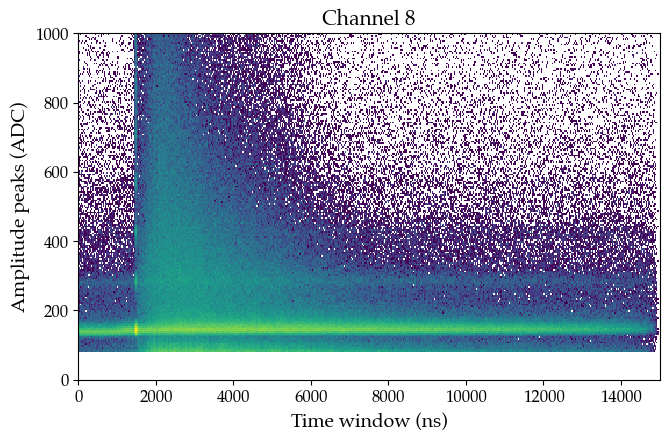

In [191]:
ch = 8
ch_idxs = np.concatenate([idx_max_ch8_10_test  [date][ch] for date in idx_max_ch8_10_test.keys()])
ch_vals = np.concatenate([height_sg_ch8_10_test[date][ch] for date in idx_max_ch8_10_test.keys()])
plt.hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 1000)), cmin=1, norm=LogNorm())
plt.xlabel('Time window (ns)',      fontsize=14)
plt.ylabel('Amplitude peaks (ADC)', fontsize=14)
plt.title(f"Channel {ch}",          fontsize=15)
plt.show()

In [192]:
uniq_ts_10_max_test, sum_ampls_10_max_test = get_t_dist_from_hit_map(2*ch_idxs, ch_vals)

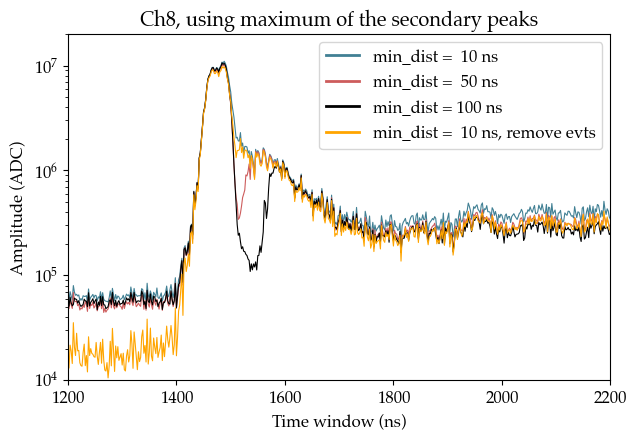

In [194]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_10_max,  sum_ampls_10_max,  lw=0.8, c=fav_col,     label=f'min_dist =  10 ns')
plt.plot(uniq_ts_50_max,  sum_ampls_50_max,  lw=0.8, c='indianred', label=f'min_dist =  50 ns')
plt.plot(uniq_ts_100_max, sum_ampls_100_max, lw=0.8, c='k',         label=f'min_dist = 100 ns')
plt.plot(uniq_ts_10_max_test,  sum_ampls_10_max_test,  lw=0.8, c='orange',     label=f'min_dist =  10 ns, remove evts')
plt.title('Ch8, using maximum of the secondary peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1200, 2200)
plt.ylim(1e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

### Reduce the number of bins:

In [113]:
uniq_ts_10_max_40bin, sum_ampls_10_max_40bin   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_10   [date]) for date in idx_max_ch8_10   .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_10 [date]) for date in height_sg_ch8_10 .keys()]), bin_size=20)
uniq_ts_10_thr_40bin, sum_ampls_10_thr_40bin   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_10   [date]) for date in idx_thr_ch8_10   .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_10 [date]) for date in height_sg_ch8_10 .keys()]), bin_size=20)
uniq_ts_20_max_40bin, sum_ampls_20_max_40bin   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20   [date]) for date in idx_max_ch8_20   .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_20 [date]) for date in height_sg_ch8_20 .keys()]), bin_size=20)
uniq_ts_20_thr_40bin, sum_ampls_20_thr_40bin   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_20   [date]) for date in idx_thr_ch8_20   .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_20 [date]) for date in height_sg_ch8_20 .keys()]), bin_size=20)
uniq_ts_30_max_40bin, sum_ampls_30_max_40bin   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_30   [date]) for date in idx_max_ch8_30   .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_30 [date]) for date in height_sg_ch8_30 .keys()]), bin_size=20)
uniq_ts_30_thr_40bin, sum_ampls_30_thr_40bin   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_30   [date]) for date in idx_thr_ch8_30   .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_30 [date]) for date in height_sg_ch8_30 .keys()]), bin_size=20)
uniq_ts_50_max_40bin, sum_ampls_50_max_40bin   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_50   [date]) for date in idx_max_ch8_50   .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_50 [date]) for date in height_sg_ch8_50 .keys()]), bin_size=20)
uniq_ts_50_thr_40bin, sum_ampls_50_thr_40bin   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_50   [date]) for date in idx_thr_ch8_50   .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_50 [date]) for date in height_sg_ch8_50 .keys()]), bin_size=20)
uniq_ts_100_max_40bin, sum_ampls_100_max_40bin = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_100  [date]) for date in idx_max_ch8_100  .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_100[date]) for date in height_sg_ch8_100.keys()]), bin_size=20)
uniq_ts_100_thr_40bin, sum_ampls_100_thr_40bin = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch8_100  [date]) for date in idx_thr_ch8_100  .keys()]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_100[date]) for date in height_sg_ch8_100.keys()]), bin_size=20)

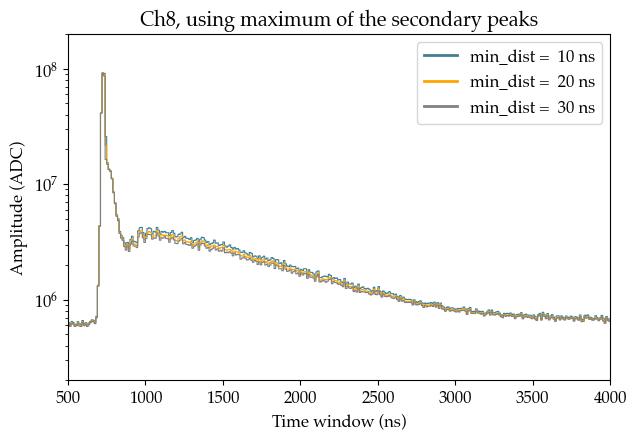

In [121]:
fig = plt.figure(figsize=(7, 4.5))
plt.step(uniq_ts_10_max_20bin, sum_ampls_10_max_20bin,   lw=0.8, c=fav_col,     label=f'min_dist =  10 ns')
plt.step(uniq_ts_20_max_20bin, sum_ampls_20_max_20bin,   lw=0.8, c='orange',    label=f'min_dist =  20 ns')
plt.step(uniq_ts_30_max_20bin, sum_ampls_30_max_20bin,   lw=0.8, c='grey',      label=f'min_dist =  30 ns')
#plt.step(uniq_ts_50_max_20bin, sum_ampls_50_max_20bin,   lw=0.8, c='indianred', label=f'min_dist =  50 ns')
#plt.step(uniq_ts_100_max_20bin, sum_ampls_100_max_20bin, lw=0.8, c='k',         label=f'min_dist = 100 ns')
plt.title('Ch8, using maximum of the secondary peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(500, 4000)
plt.ylim(2e5, 2e8)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

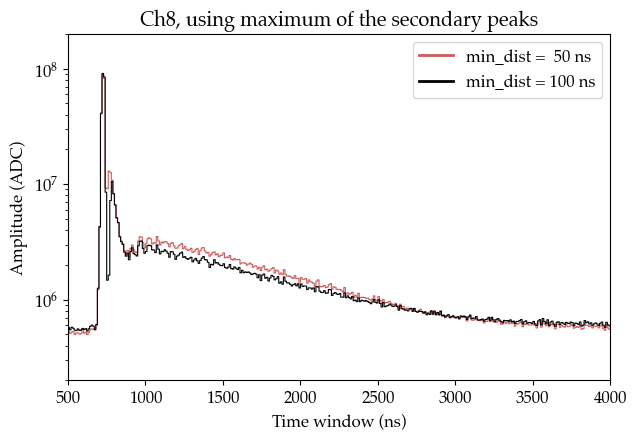

In [141]:
fig = plt.figure(figsize=(7, 4.5))
plt.step(uniq_ts_50_max_20bin, sum_ampls_50_max_20bin,   lw=0.8, c='indianred', label=f'min_dist =  50 ns')
plt.step(uniq_ts_100_max_20bin, sum_ampls_100_max_20bin, lw=0.8, c='k',         label=f'min_dist = 100 ns')
plt.title('Ch8, using maximum of the secondary peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(500, 4000)
plt.ylim(2e5, 2e8)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

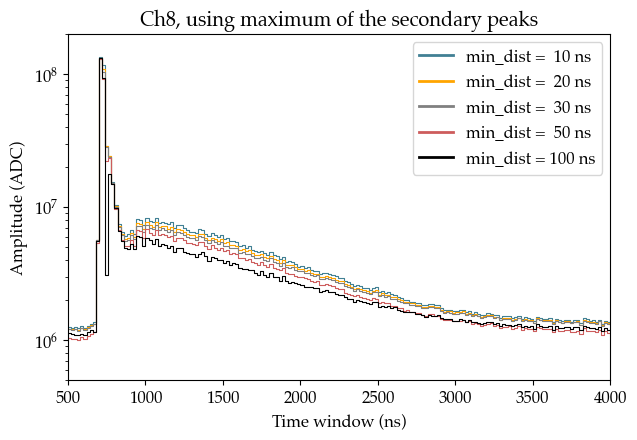

In [118]:
fig = plt.figure(figsize=(7, 4.5))
plt.step(uniq_ts_10_max_40bin, sum_ampls_10_max_40bin,   lw=0.8, c=fav_col,     label=f'min_dist =  10 ns')
plt.step(uniq_ts_20_max_40bin, sum_ampls_20_max_40bin,   lw=0.8, c='orange',    label=f'min_dist =  20 ns')
plt.step(uniq_ts_30_max_40bin, sum_ampls_30_max_40bin,   lw=0.8, c='grey',      label=f'min_dist =  30 ns')
plt.step(uniq_ts_50_max_40bin, sum_ampls_50_max_40bin,   lw=0.8, c='indianred', label=f'min_dist =  50 ns')
plt.step(uniq_ts_100_max_40bin, sum_ampls_100_max_40bin, lw=0.8, c='k',         label=f'min_dist = 100 ns')
plt.title('Ch8, using maximum of the secondary peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(500, 4000)
plt.ylim(5e5, 2e8)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

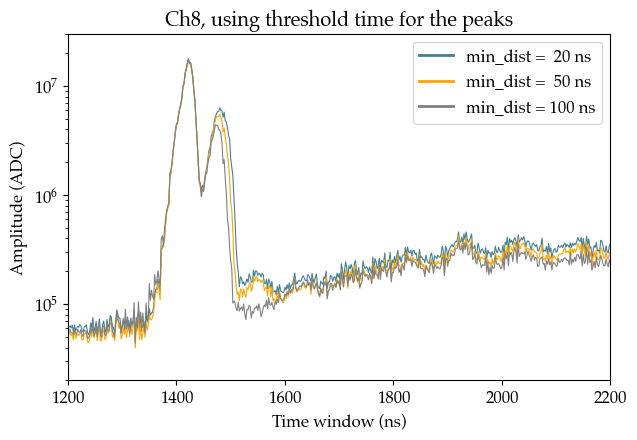

In [13]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_20_thr,  sum_ampls_20_thr,  lw=0.8, c=fav_col,  label=f'min_dist =  20 ns')
plt.plot(uniq_ts_50_thr,  sum_ampls_50_thr,  lw=0.8, c='orange', label=f'min_dist =  50 ns')
plt.plot(uniq_ts_100_thr, sum_ampls_100_thr, lw=0.8, c='grey',   label=f'min_dist = 100 ns')
plt.title('Ch8, using threshold time for the peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1200, 2200)
plt.ylim(2e4, 3e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

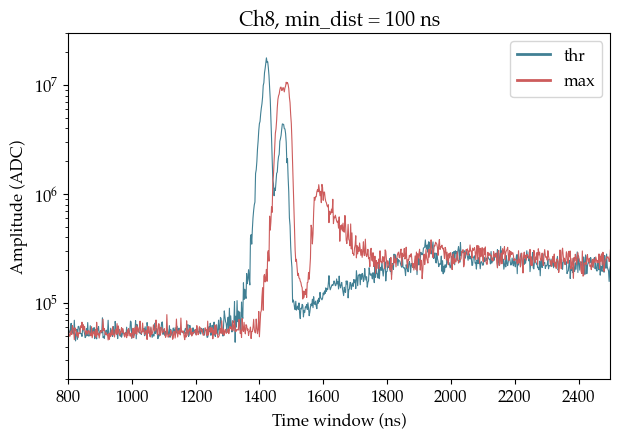

In [206]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_100_thr, sum_ampls_100_thr, lw=0.8, c=fav_col,     label=f'thr')
plt.plot(uniq_ts_100_max, sum_ampls_100_max, lw=0.8, c='indianred', label=f'max')
plt.title('Ch8, min_dist = 100 ns')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 2500)
plt.ylim(2e4, 3e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

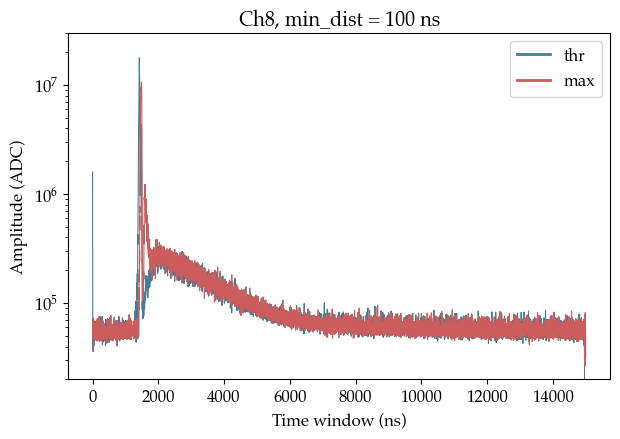

In [207]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_100_thr, sum_ampls_100_thr, lw=0.8, c=fav_col,     label=f'thr')
plt.plot(uniq_ts_100_max, sum_ampls_100_max, lw=0.8, c='indianred', label=f'max')
plt.title('Ch8, min_dist = 100 ns')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
#plt.xlim(800, 2500)
plt.ylim(2e4, 3e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

### Study different months

In [14]:
_, idx_max_ch8_20_09, idx_thr_ch8_20_09, height_sg_ch8_20_09 = get_ch_info(10, month='09', ch=8)
_, idx_max_ch8_20_10, idx_thr_ch8_20_10, height_sg_ch8_20_10 = get_ch_info(10, month='10', ch=8)
_, idx_max_ch8_20_11, idx_thr_ch8_20_11, height_sg_ch8_20_11 = get_ch_info(10, month='11', ch=8)
_, idx_max_ch8_20_12, idx_thr_ch8_20_12, height_sg_ch8_20_12 = get_ch_info(10, month='12', ch=8)
_, idx_max_ch8_20_01, idx_thr_ch8_20_01, height_sg_ch8_20_01 = get_ch_info(10, month='01', ch=8)

288
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
359
0
10_04_2024
20
40
60
80
10_11_2024
100
120
140
160
10_17_2024
180
200
220
240
260
10_25_2024
280
300
320
340
292
0
11_01_2024
20
40
60
80
11_11_2024
100
120
140
160
180
11_25_2024
200
220
240
260
280
181
0
12_13_2024
20
40
60
80
12_21_2024
100
120
140
160
180
263
0
01_02_2025
20
40
60
80
01_10_2025
100
120
140
160
01_19_2025
180
200
220
240
260


In [15]:
uniq_ts_20_09_max, sum_ampls_20_09_max = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_09  [date]) for date in idx_max_ch8_20_09  .keys() if date.startswith('09')]),
                                                                   np.concatenate([np.concatenate(height_sg_ch8_20_09[date]) for date in height_sg_ch8_20_09.keys() if date.startswith('09')]))
uniq_ts_20_10_max, sum_ampls_20_10_max = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_10  [date]) for date in idx_max_ch8_20_10  .keys() if date.startswith('10')]),
                                                                   np.concatenate([np.concatenate(height_sg_ch8_20_10[date]) for date in height_sg_ch8_20_10.keys() if date.startswith('10')]))
uniq_ts_20_11_max, sum_ampls_20_11_max = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_11  [date]) for date in idx_max_ch8_20_11  .keys() if date.startswith('11')]),
                                                                   np.concatenate([np.concatenate(height_sg_ch8_20_11[date]) for date in height_sg_ch8_20_11.keys() if date.startswith('11')]))
uniq_ts_20_12_max, sum_ampls_20_12_max = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_12  [date]) for date in idx_max_ch8_20_12  .keys() if date.startswith('12')]),
                                                                   np.concatenate([np.concatenate(height_sg_ch8_20_12[date]) for date in height_sg_ch8_20_12.keys() if date.startswith('12')]))
uniq_ts_20_01_max, sum_ampls_20_01_max = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_01  [date]) for date in idx_max_ch8_20_01  .keys() if date.startswith('01')]),
                                                                   np.concatenate([np.concatenate(height_sg_ch8_20_01[date]) for date in height_sg_ch8_20_01.keys() if date.startswith('01')]))

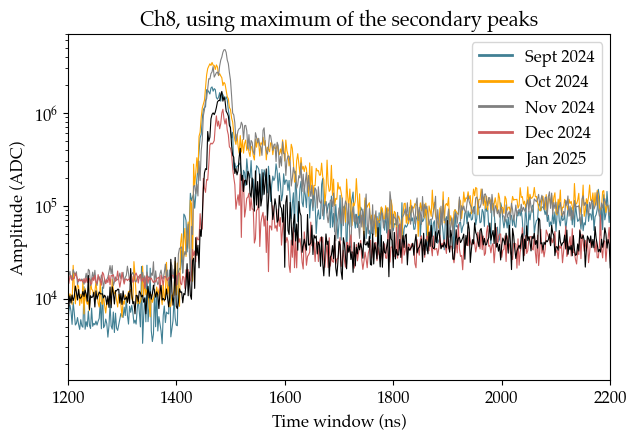

In [66]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_20_09_max, sum_ampls_20_09_max, lw=0.8, c=fav_col,     label='Sept 2024')
plt.plot(uniq_ts_20_10_max, sum_ampls_20_10_max, lw=0.8, c='orange',    label='Oct 2024')
plt.plot(uniq_ts_20_11_max, sum_ampls_20_11_max, lw=0.8, c='grey',      label='Nov 2024')
plt.plot(uniq_ts_20_12_max, sum_ampls_20_12_max, lw=0.8, c='indianred', label='Dec 2024')
plt.plot(uniq_ts_20_01_max, sum_ampls_20_01_max, lw=0.8, c='k',         label='Jan 2025')
plt.title('Ch8, using maximum of the secondary peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1200, 2200)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Try with calibrated values and same number of files:

In [17]:
_, idx_max_ch8_20_09_cal, idx_thr_ch8_20_09_cal, height_sg_ch8_20_09_cal = get_ch_info(10, month='09', ch=8, cal=True, nfiles=150)
_, idx_max_ch8_20_10_cal, idx_thr_ch8_20_10_cal, height_sg_ch8_20_10_cal = get_ch_info(10, month='10', ch=8, cal=True, nfiles=150)
_, idx_max_ch8_20_11_cal, idx_thr_ch8_20_11_cal, height_sg_ch8_20_11_cal = get_ch_info(10, month='11', ch=8, cal=True, nfiles=150)
_, idx_max_ch8_20_12_cal, idx_thr_ch8_20_12_cal, height_sg_ch8_20_12_cal = get_ch_info(10, month='12', ch=8, cal=True, nfiles=150)
_, idx_max_ch8_20_01_cal, idx_thr_ch8_20_01_cal, height_sg_ch8_20_01_cal = get_ch_info(10, month='01', ch=8, cal=True, nfiles=150)

288
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
359
0
10_04_2024
20
40
60
80
10_11_2024
100
120
140
292
0
11_01_2024
20
40
60
80
11_11_2024
100
120
140
181
0
12_13_2024
20
40
60
80
12_21_2024
100
120
140
263
0
01_02_2025
20
40
60
80
01_10_2025
100
120
140


In [18]:
uniq_ts_20_09_max_cal, sum_ampls_20_09_max_cal = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_09_cal  [date]) for date in idx_max_ch8_20_09_cal  .keys() if date.startswith('09')]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_20_09_cal[date]) for date in height_sg_ch8_20_09_cal.keys() if date.startswith('09')]))
uniq_ts_20_10_max_cal, sum_ampls_20_10_max_cal = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_10_cal  [date]) for date in idx_max_ch8_20_10_cal  .keys() if date.startswith('10')]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_20_10_cal[date]) for date in height_sg_ch8_20_10_cal.keys() if date.startswith('10')]))
uniq_ts_20_11_max_cal, sum_ampls_20_11_max_cal = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_11_cal  [date]) for date in idx_max_ch8_20_11_cal  .keys() if date.startswith('11')]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_20_11_cal[date]) for date in height_sg_ch8_20_11_cal.keys() if date.startswith('11')]))
uniq_ts_20_12_max_cal, sum_ampls_20_12_max_cal = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_12_cal  [date]) for date in idx_max_ch8_20_12_cal  .keys() if date.startswith('12')]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_20_12_cal[date]) for date in height_sg_ch8_20_12_cal.keys() if date.startswith('12')]))
uniq_ts_20_01_max_cal, sum_ampls_20_01_max_cal = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch8_20_01_cal  [date]) for date in idx_max_ch8_20_01_cal  .keys() if date.startswith('01')]),
                                                                           np.concatenate([np.concatenate(height_sg_ch8_20_01_cal[date]) for date in height_sg_ch8_20_01_cal.keys() if date.startswith('01')]))

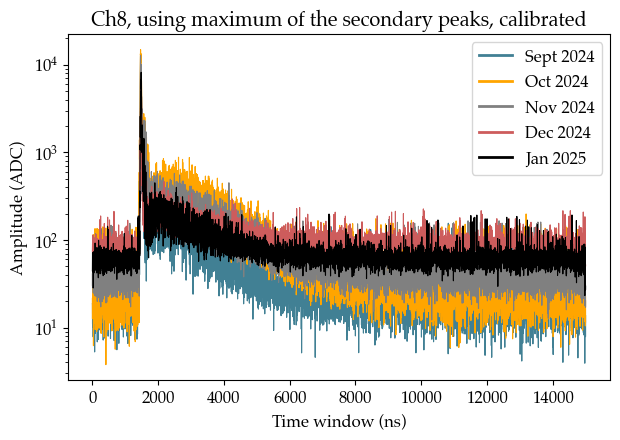

In [67]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_20_09_max_cal, sum_ampls_20_09_max_cal, lw=0.8, c=fav_col,     label='Sept 2024')
plt.plot(uniq_ts_20_10_max_cal, sum_ampls_20_10_max_cal, lw=0.8, c='orange',    label='Oct 2024')
plt.plot(uniq_ts_20_11_max_cal, sum_ampls_20_11_max_cal, lw=0.8, c='grey',      label='Nov 2024')
plt.plot(uniq_ts_20_12_max_cal, sum_ampls_20_12_max_cal, lw=0.8, c='indianred', label='Dec 2024')
plt.plot(uniq_ts_20_01_max_cal, sum_ampls_20_01_max_cal, lw=0.8, c='k',         label='Jan 2025')
plt.title('Ch8, using maximum of the secondary peaks, calibrated')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
#plt.xlim(1200, 2200)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Try with pretrigger and high light cut:

In [29]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/'

thr_ADC        = 80
sg_filt_window = 30
min_dist       = 10

filt_files   = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_ch8_run-*')
sorted_files = sorted(filt_files, key=extract_date_obj_and_number)

start_time = time.time()
idx_thr_ch8_pt   = {}
idx_max_ch8_pt   = {}
height_sg_ch8_pt = {}
num_evts_ch8_pt  = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in [8]:
        idx_after_cut1   = []
        idx_after_cut2   = []
        height_after_cut = []
        num_evts         = 0
        idx_thr_ch = d['idx_peaks_thr']  .item()[ch]
        idx_max_ch = d['idx_peaks_max']  .item()[ch]
        heights_ch = d['height_peaks_sg'].item()[ch]
        
        for idxs1, idxs2, vals in zip(idx_thr_ch, idx_max_ch, heights_ch):
            if len(idxs2)==0:
                continue
            noise_evts = (np.array(idxs2)<650)&(np.array(vals)>100) ## Pretrigger cut
            if np.any(noise_evts):
                continue
            else:
                idx_after_cut1  .append(idxs1)
                idx_after_cut2  .append(idxs2)
                height_after_cut.append(vals)
                num_evts += 1
                
        if date not in idx_max_ch8_pt:
            print(date)
            idx_thr_ch8_pt  [date] = {}
            idx_max_ch8_pt  [date] = {}
            height_sg_ch8_pt[date] = {}
            num_evts_ch8_pt [date] = {}

        if ch not in idx_max_ch8_pt[date]:
            try:
                idx_thr_ch8_pt  [date][ch] = np.concatenate(idx_after_cut1)
                idx_max_ch8_pt  [date][ch] = np.concatenate(idx_after_cut2)
                height_sg_ch8_pt[date][ch] = np.concatenate(height_after_cut)
                num_evts_ch8_pt [date][ch] = np.array([num_evts])
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_thr_ch8_pt  [date][ch] = np.concatenate((idx_thr_ch8_pt  [date][ch], np.concatenate(idx_after_cut1)))
                idx_max_ch8_pt  [date][ch] = np.concatenate((idx_max_ch8_pt  [date][ch], np.concatenate(idx_after_cut2)))
                height_sg_ch8_pt[date][ch] = np.concatenate((height_sg_ch8_pt[date][ch], np.concatenate(height_after_cut)))
                num_evts_ch8_pt [date][ch] = np.concatenate((num_evts_ch8_pt [date][ch], np.array([num_evts])))
            except Exception as e:
                print(e)
                continue

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1383
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
580
600
620
640
11_01_2024
660
680
700
720
11_11_2024
740
760
780
800
820
11_25_2024
840
860
880
900
920
12_13_2024
940
960
980
1000
1020
12_21_2024
1040
1060
1080
1100
1120
01_02_2025
1140
1160
1180
1200
01_10_2025
1220
1240
1260
1280
01_19_2025
1300
1320
1340
1360
1380
Elapsed time: 14.795441150665283 s, 0.2465906858444214 min


In [32]:
uniq_ts_thr_pt_ch8, sum_ampls_thr_pt_ch8 = get_t_dist_from_hit_map(2*np.concatenate([idx_thr_ch8_pt  [date][8] for date in idx_thr_ch8_pt  .keys()]),
                                                                     np.concatenate([height_sg_ch8_pt[date][8] for date in height_sg_ch8_pt.keys()]))
uniq_ts_max_pt_ch8, sum_ampls_max_pt_ch8 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_ch8_pt  [date][8] for date in idx_max_ch8_pt  .keys()]),
                                                                     np.concatenate([height_sg_ch8_pt[date][8] for date in height_sg_ch8_pt.keys()]))

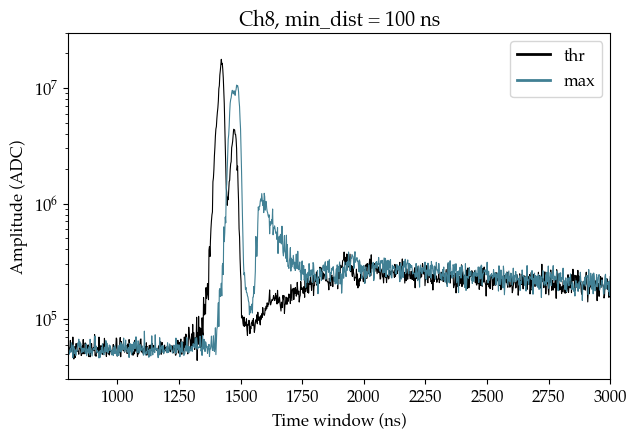

In [215]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_100_thr, sum_ampls_100_thr, lw=0.8, c='k',     label=f'thr')
plt.plot(uniq_ts_100_max, sum_ampls_100_max, lw=0.8, c=fav_col, label=f'max')
plt.title('Ch8, min_dist = 100 ns')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 3000)
plt.ylim(3e4, 3e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

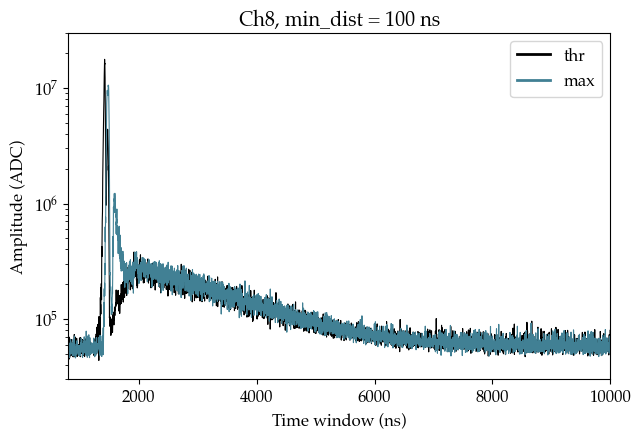

In [216]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_100_thr, sum_ampls_100_thr, lw=0.8, c='k',     label=f'thr')
plt.plot(uniq_ts_100_max, sum_ampls_100_max, lw=0.8, c=fav_col, label=f'max')
plt.title('Ch8, min_dist = 100 ns')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 10000)
plt.ylim(3e4, 3e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

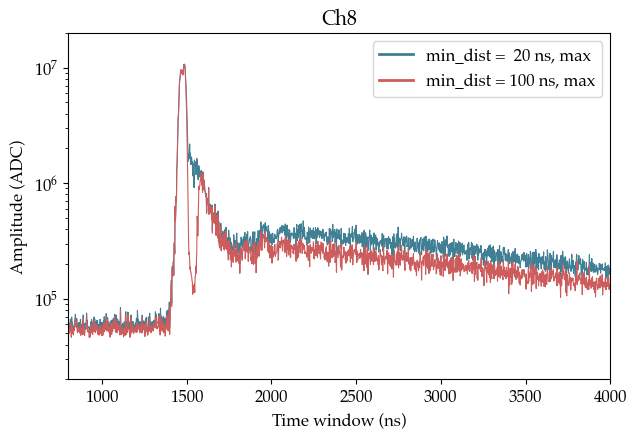

In [58]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_20_max,     sum_ampls_20_max,     lw=0.8, c=fav_col,     label=f'min_dist =  20 ns, max')
plt.plot(uniq_ts_100_max,    sum_ampls_100_max,    lw=0.8, c='indianred', label=f'min_dist = 100 ns, max')
plt.title('Ch8')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 4000)
plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

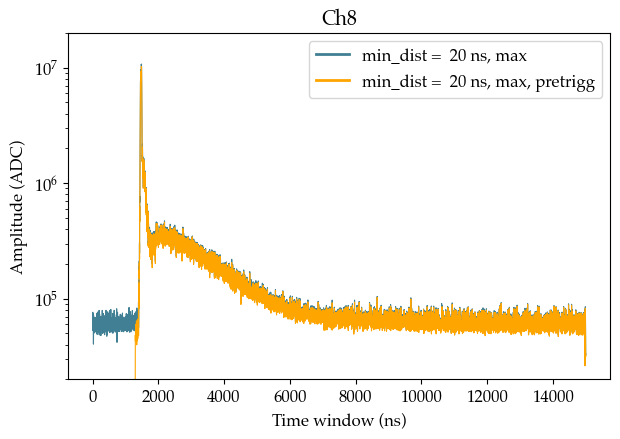

In [63]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_20_max,     sum_ampls_20_max,     lw=0.8, c=fav_col,     label=f'min_dist =  20 ns, max')
#plt.plot(uniq_ts_100_max,    sum_ampls_100_max,    lw=0.8, c='indianred', label=f'min_dist = 100 ns, max')
plt.plot(uniq_ts_max_pt_ch8, sum_ampls_max_pt_ch8, lw=0.8, c='orange',    label=f'min_dist =  20 ns, max, pretrigg')
#plt.plot(uniq_ts_thr_pt_ch8, sum_ampls_thr_pt_ch8, lw=0.8, c='grey',      label=f'min_dist =  20 ns, thr, pretrigg')
plt.title('Ch8')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
#plt.xlim(800, 4000)
plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Try LLAMA cuts

In [45]:
start_time = time.time()

filt_evts_dict_ch8_1pe = {}
idx_max_ch8_1pe        = {}
height_sg_ch8_1pe      = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)

    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    all_evts       = np.concatenate(list(d['filt_evts_dict'].item().values()))
    uniq_evts, cts = np.unique(all_evts, return_counts=True)
    uniq_evts_arr  = uniq_evts[cts == 1] ## Multiplicity cut between SiPMs
    
    for ch in [8]:
        
        npeak_wf = np.array([len(el) for el in d['idx_peaks_max'].item()[ch]])
        sel1     = np.isin(d['filt_evts_dict'].item()[ch], uniq_evts_arr)
        sel2     = npeak_wf==1
        sel_evts =                d['filt_evts_dict'] .item()[ch][sel1&sel2]
        indices1 = np.concatenate(d['idx_peaks_max']  .item()[ch][sel1&sel2]).astype(int)
        heights1 = np.concatenate(d['height_peaks_sg'].item()[ch][sel1&sel2])
        
        sel3     = heights1 < 200 #amplitude < 200 ADC to select only single PE
        sel_evts = sel_evts[sel3]
        indices1 = indices1[sel3]
        heights1 = heights1[sel3]
        
    
        if date not in filt_evts_dict_ch8_1pe:
            filt_evts_dict_ch8_1pe[date] = {}
            idx_max_ch8_1pe       [date] = {}
            height_sg_ch8_1pe     [date] = {}
            
        if ch not in filt_evts_dict_ch8_1pe[date]:
            try:
                filt_evts_dict_ch8_1pe[date][ch] = sel_evts
                idx_max_ch8_1pe       [date][ch] = indices1
                height_sg_ch8_1pe     [date][ch] = heights1
            except Exception as e:
                print(e)
                continue
                
        else:
            try:
                filt_evts_dict_ch8_1pe[date][ch] = np.concatenate((filt_evts_dict_ch8_1pe[date][ch], sel_evts))
                idx_max_ch8_1pe       [date][ch] = np.concatenate((idx_max_ch8_1pe       [date][ch], indices1))
                height_sg_ch8_1pe     [date][ch] = np.concatenate((height_sg_ch8_1pe     [date][ch], heights1))
            except Exception as e:
                print(e)
                continue
                
end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1383
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
Elapsed time: 45.40239095687866 s, 0.7567065159479777 min


In [46]:
uniq_ts_max_1pe_ch8, sum_ampls_max_1pe_ch8 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_ch8_1pe  [date][8] for date in idx_max_ch8_1pe  .keys()]),
                                                                       np.concatenate([height_sg_ch8_1pe[date][8] for date in height_sg_ch8_1pe.keys()]))

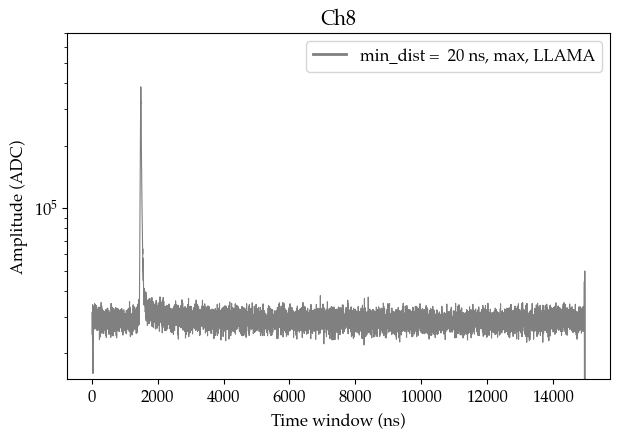

In [69]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_max_1pe_ch8, sum_ampls_max_1pe_ch8, lw=0.8, c='grey', label=f'min_dist =  20 ns, max, LLAMA')
plt.title('Ch8')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
#plt.xlim(800, 4000)
plt.ylim(1.5e4, 7e5)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

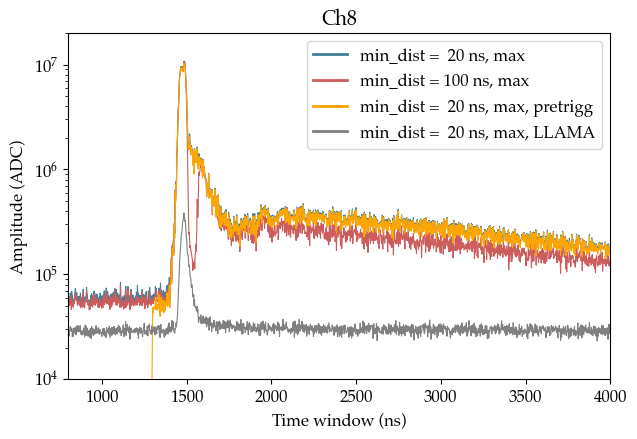

In [53]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_20_max,     sum_ampls_20_max,       lw=0.8, c=fav_col,     label=f'min_dist =  20 ns, max')
plt.plot(uniq_ts_100_max,    sum_ampls_100_max,      lw=0.8, c='indianred', label=f'min_dist = 100 ns, max')
plt.plot(uniq_ts_max_pt_ch8, sum_ampls_max_pt_ch8,   lw=0.8, c='orange',    label=f'min_dist =  20 ns, max, pretrigg')
plt.plot(uniq_ts_max_1pe_ch8, sum_ampls_max_1pe_ch8, lw=0.8, c='grey',      label=f'min_dist =  20 ns, max, LLAMA')
plt.title('Ch8')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 4000)
plt.ylim(1e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

### Deconv cut

In [72]:
min_dist      = 50
filt_files2   = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_run-*')
sorted_files2 = sorted(filt_files2, key=extract_date_obj_and_number)

start_time = time.time()

filt_evts_dict = {}
idx_max_d      = {}
idx_thr_d      = {}
height_sg_d    = {}

print(len(sorted_files2))
for ifile,filename in enumerate(sorted_files2):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)

    if date not in filt_evts_dict:
        print(date)
        filt_evts_dict[date] = {ch: d['filt_evts_dict']                       .item()[ch]  for ch in [8]}
        idx_max_d     [date] = {ch: np.concatenate(d['idx_peaks_max']         .item()[ch]) for ch in [8]}
        idx_thr_d     [date] = {ch: np.concatenate(d['idx_peaks_thr']         .item()[ch]) for ch in [8]}
        height_sg_d   [date] = {ch: np.concatenate(d['height_peaks_sg_deconv'].item()[ch]) for ch in [8]}

    else:
        for ch in [8]:
            try:
                filt_evts_dict[date][ch] = np.concatenate((filt_evts_dict[date][ch], adapt_evt_id(d['filt_evts_dict']          .item()[ch], fnum)))
                idx_max_d     [date][ch] = np.concatenate((idx_max_d     [date][ch], np.concatenate(d['idx_peaks_max']         .item()[ch])))
                idx_thr_d     [date][ch] = np.concatenate((idx_thr_d     [date][ch], np.concatenate(d['idx_peaks_thr']         .item()[ch])))
                height_sg_d   [date][ch] = np.concatenate((height_sg_d   [date][ch], np.concatenate(d['height_peaks_sg_deconv'].item()[ch])))
            
            except Exception as e:
                print(date, fnum, filename, ch, str(e))
                continue
                
end_time     = time.time()                
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1380
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
580
600
620
640
11_01_2024
660
680
700
720
11_11_2024
740
760
780
800
820
11_25_2024
840
860
880
900
920
12_13_2024
940
960
980
1000
1020
12_21_2024
1040
1060
1080
1100
01_02_2025
1120
1140
1160
1180
1200
01_10_2025
1220
1240
1260
1280
01_19_2025
1300
1320
1340
1360
Elapsed time: 44.16486406326294 s, 0.736081067721049 min


In [73]:
uniq_ts_thr_d_ch8, sum_ampls_thr_d_ch8 = get_t_dist_from_hit_map(2*np.concatenate([idx_thr_d  [date][8] for date in idx_thr    .keys()]),
                                                                   np.concatenate([height_sg_d[date][8] for date in height_sg_d.keys()]))
uniq_ts_max_d_ch8, sum_ampls_max_d_ch8 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_d  [date][8] for date in idx_max    .keys()]),
                                                                   np.concatenate([height_sg_d[date][8] for date in height_sg_d.keys()]))

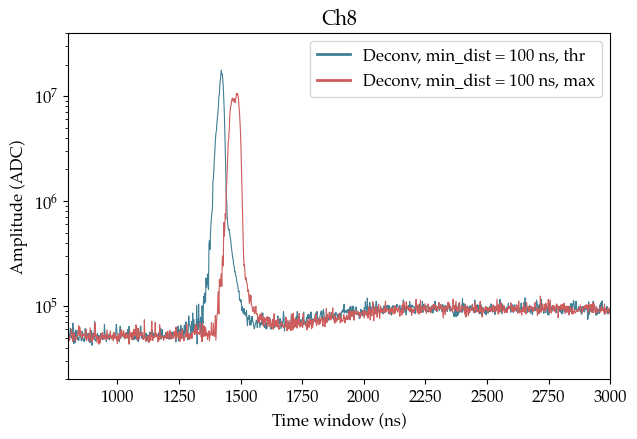

In [77]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_thr_d_ch8, sum_ampls_thr_d_ch8, lw=0.8, c=fav_col,     label=f'Deconv, min_dist = 100 ns, thr')
plt.plot(uniq_ts_max_d_ch8, sum_ampls_max_d_ch8, lw=0.8, c='indianred', label=f'Deconv, min_dist = 100 ns, max')
plt.title('Ch8')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(800, 3000)
plt.ylim(2e4, 4e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

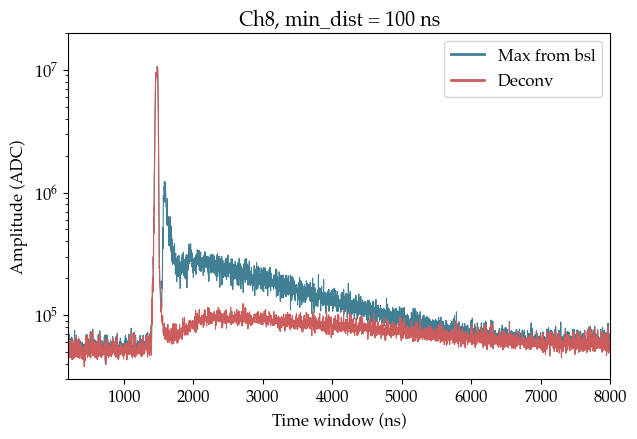

In [210]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_100_max,   sum_ampls_100_max,   lw=0.8, c=fav_col,     label=f'Max from bsl')
plt.plot(uniq_ts_max_d_ch8, sum_ampls_max_d_ch8, lw=0.8, c='indianred', label=f'Deconv')
plt.title('Ch8, min_dist = 100 ns')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(200, 8000)
plt.ylim(3e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## Same studies with trigger channel 9

In [20]:
idx_max_ch9_50,  idx_thr_ch9_50,  height_sg_ch9_50  = get_ch_info(25, ch=9, nfiles=100)
idx_max_ch9_100, idx_thr_ch9_100, height_sg_ch9_100 = get_ch_info(50, ch=9, nfiles=100)

1383
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
Elapsed time: 6.318782091140747 s, 0.10531303485234579 min
1379
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
Elapsed time: 17.864593029022217 s, 0.2977432171503703 min


In [21]:
uniq_ts_ch9_50_max, sum_ampls_ch9_50_max   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch9_50   [date]) for date in idx_max_ch9_50   .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_50 [date]) for date in height_sg_ch9_50 .keys()]))
uniq_ts_ch9_50_thr, sum_ampls_ch9_50_thr   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch9_50   [date]) for date in idx_thr_ch9_50   .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_50 [date]) for date in height_sg_ch9_50 .keys()]))
uniq_ts_ch9_100_max, sum_ampls_ch9_100_max = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch9_100  [date]) for date in idx_max_ch9_100  .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_100[date]) for date in height_sg_ch9_100.keys()]))
uniq_ts_ch9_100_thr, sum_ampls_ch9_100_thr = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch9_100  [date]) for date in idx_thr_ch9_100  .keys()]),
                                                                       np.concatenate([np.concatenate(height_sg_ch9_100[date]) for date in height_sg_ch9_100.keys()]))

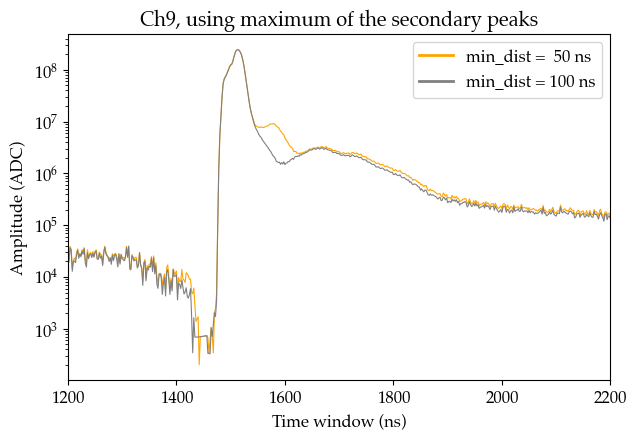

In [22]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_ch9_50_max,  sum_ampls_ch9_50_max,  lw=0.8, c='orange', label=f'min_dist =  50 ns')
plt.plot(uniq_ts_ch9_100_max, sum_ampls_ch9_100_max, lw=0.8, c='grey',   label=f'min_dist = 100 ns')
plt.title('Ch9, using maximum of the secondary peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1200, 2200)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

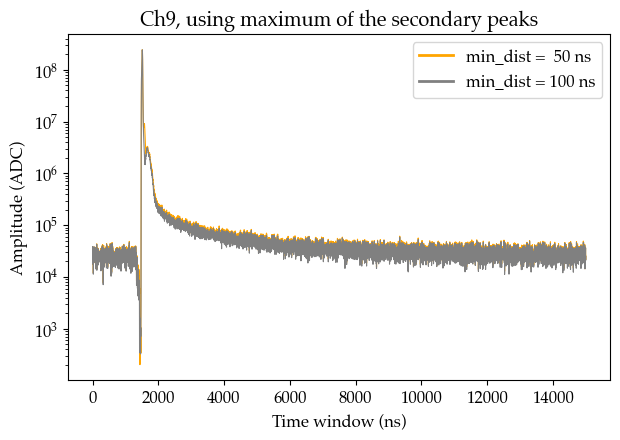

In [23]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_ch9_50_max,  sum_ampls_ch9_50_max,  lw=0.8, c='orange', label=f'min_dist =  50 ns')
plt.plot(uniq_ts_ch9_100_max, sum_ampls_ch9_100_max, lw=0.8, c='grey',   label=f'min_dist = 100 ns')
plt.title('Ch9, using maximum of the secondary peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

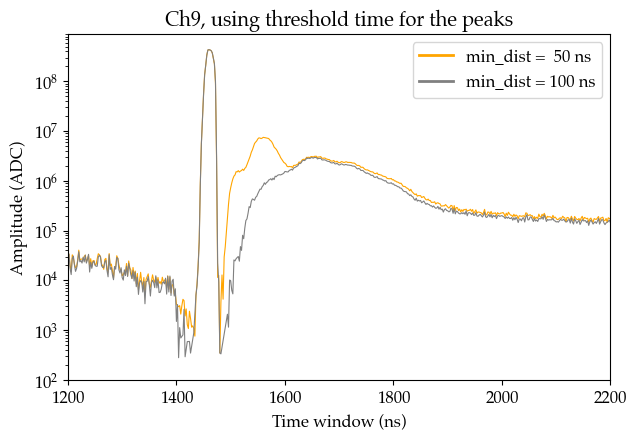

In [24]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_ch9_50_thr,  sum_ampls_ch9_50_thr,  lw=0.8, c='orange', label=f'min_dist =  50 ns')
plt.plot(uniq_ts_ch9_100_thr, sum_ampls_ch9_100_thr, lw=0.8, c='grey',   label=f'min_dist = 100 ns')
plt.title('Ch9, using threshold time for the peaks')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1200, 2200)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

In [25]:
idx_max_ch9_20_cal,  idx_thr_ch9_20_cal,  height_sg_ch9_20_cal  = get_ch_info(10, ch=9, nfiles=200, cal=True)
idx_max_ch9_50_cal,  idx_thr_ch9_50_cal,  height_sg_ch9_50_cal  = get_ch_info(25, ch=9, nfiles=200, cal=True)
idx_max_ch9_100_cal, idx_thr_ch9_100_cal, height_sg_ch9_100_cal = get_ch_info(50, ch=9, nfiles=200, cal=True)

1367
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
09_25_2024
160
180
Elapsed time: 18.959327936172485 s, 0.31598879893620807 min
1383
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
Elapsed time: 18.91059899330139 s, 0.31517664988835653 min
1379
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
Elapsed time: 45.087592124938965 s, 0.7514598687489827 min


In [26]:
uniq_ts_ch9_20_max_cal, sum_ampls_ch9_20_max_cal   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch9_20_cal   [date]) for date in idx_max_ch9_20_cal   .keys()]),
                                                                               np.concatenate([np.concatenate(height_sg_ch9_20_cal [date]) for date in height_sg_ch9_20_cal .keys()]))
uniq_ts_ch9_20_thr_cal, sum_ampls_ch9_20_thr_cal   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch9_20_cal   [date]) for date in idx_thr_ch9_20_cal   .keys()]),
                                                                               np.concatenate([np.concatenate(height_sg_ch9_20_cal [date]) for date in height_sg_ch9_20_cal .keys()]))
uniq_ts_ch9_50_max_cal, sum_ampls_ch9_50_max_cal   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch9_50_cal   [date]) for date in idx_max_ch9_50_cal   .keys()]),
                                                                               np.concatenate([np.concatenate(height_sg_ch9_50_cal [date]) for date in height_sg_ch9_50_cal .keys()]))
uniq_ts_ch9_50_thr_cal, sum_ampls_ch9_50_thr_cal   = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch9_50_cal   [date]) for date in idx_thr_ch9_50_cal   .keys()]),
                                                                               np.concatenate([np.concatenate(height_sg_ch9_50_cal [date]) for date in height_sg_ch9_50_cal .keys()]))
uniq_ts_ch9_100_max_cal, sum_ampls_ch9_100_max_cal = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_max_ch9_100_cal  [date]) for date in idx_max_ch9_100_cal  .keys()]),
                                                                               np.concatenate([np.concatenate(height_sg_ch9_100_cal[date]) for date in height_sg_ch9_100_cal.keys()]))
uniq_ts_ch9_100_thr_cal, sum_ampls_ch9_100_thr_cal = get_t_dist_from_hit_map(2*np.concatenate([np.concatenate(idx_thr_ch9_100_cal  [date]) for date in idx_thr_ch9_100_cal  .keys()]),
                                                                               np.concatenate([np.concatenate(height_sg_ch9_100_cal[date]) for date in height_sg_ch9_100_cal.keys()]))

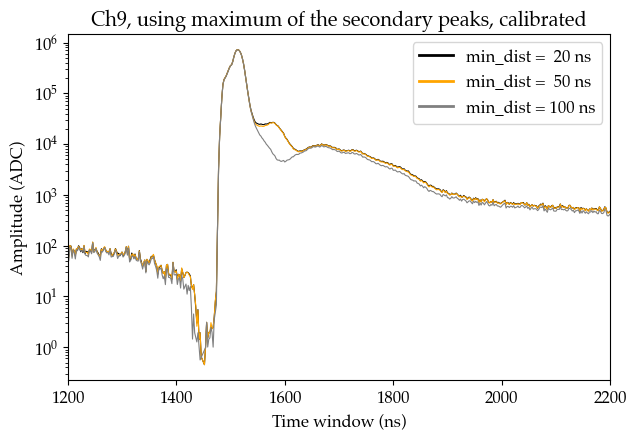

In [27]:
fig = plt.figure(figsize=(7, 4.5))
plt.plot(uniq_ts_ch9_20_max_cal,  sum_ampls_ch9_20_max_cal,  lw=0.8, c='k',      label=f'min_dist =  20 ns')
plt.plot(uniq_ts_ch9_50_max_cal,  sum_ampls_ch9_50_max_cal,  lw=0.8, c='orange', label=f'min_dist =  50 ns')
plt.plot(uniq_ts_ch9_100_max_cal, sum_ampls_ch9_100_max_cal, lw=0.8, c='grey',   label=f'min_dist = 100 ns')
plt.title('Ch9, using maximum of the secondary peaks, calibrated')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.xlim(1200, 2200)
#plt.ylim(2e4, 2e7)
leg = plt.legend(loc='upper right')
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

### Look at events with low min_dist

In [82]:
filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-11_25_2024-file.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

In [88]:
len(filt_evts_ch8_10['11_25_2024']), len(filt_evts_ch8_20['11_25_2024']), len(filt_evts_ch8_50['11_25_2024']), len(filt_evts_ch8_100['11_25_2024'])

(380251, 380251, 380251, 380251)

In [220]:
sel_evts = []
sel_peaks_10 = []
sel_peaks_30 = []
sel_peaks_50 = []
for i,(j,k,l) in enumerate(zip(idx_max_ch8_10['11_25_2024'][:300], idx_max_ch8_30['11_25_2024'], idx_max_ch8_50['11_25_2024'])):
    if len(j)!=len(k):
        print(filt_evts_ch8_10['11_25_2024'][i], j,k,l)
        sel_evts.append(filt_evts_ch8_10['11_25_2024'][i])
        sel_peaks_10.append(j)
        sel_peaks_30.append(k)
        sel_peaks_50.append(l)

39 [1779 1810 1817] [1779 1817] [1779 1817]
48 [ 747 1003 1030 1038 1046 1155 1175 1204 1279 1344 1499 1624 1879 2807
 3007 3764 3956 4003] [ 747 1003 1030 1046 1155 1175 1204 1279 1344 1499 1624 1879 2807 3007
 3764 3956 4003] [ 747 1003 1030 1155 1204 1279 1344 1499 1624 1879 2807 3007 3764 3956
 4003]
959 [3513 3550 3560] [3513 3560] [3513 3560]
1160 [4867 4884 4894] [4867 4884] [4867 4894]
1298 [5514 5538 5549 5561] [5514 5538 5561] [5514 5561]
1387 [1655 1670 1684 1691] [1655 1691] [1655 1691]
1490 [1325 1347 1359] [1325 1347] [1325 1359]


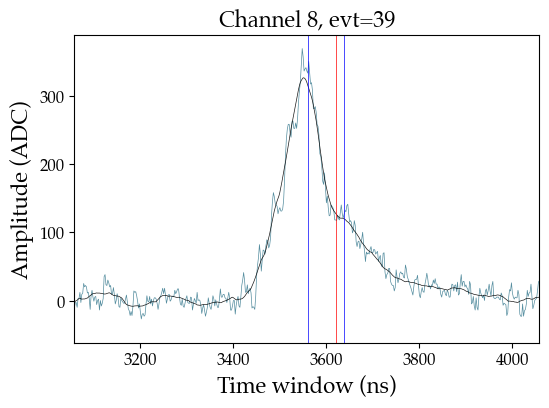

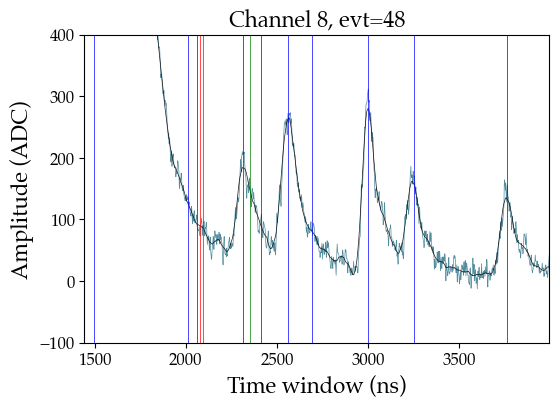

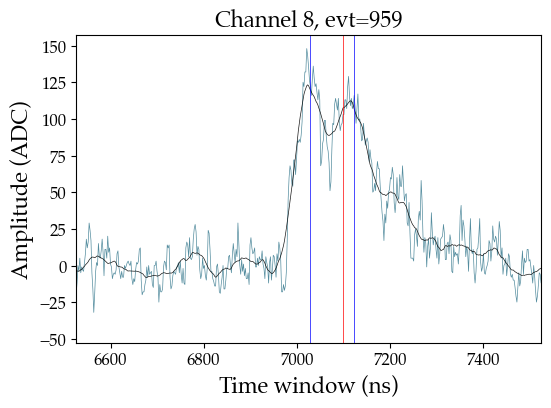

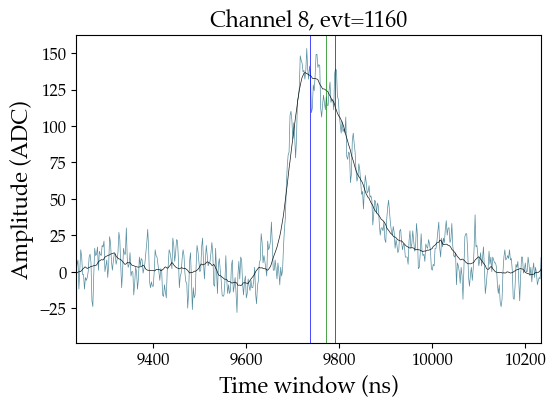

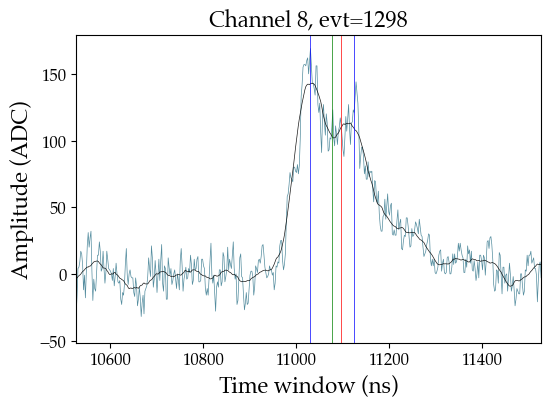

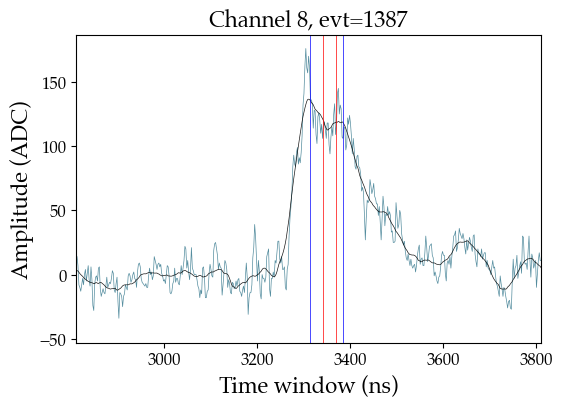

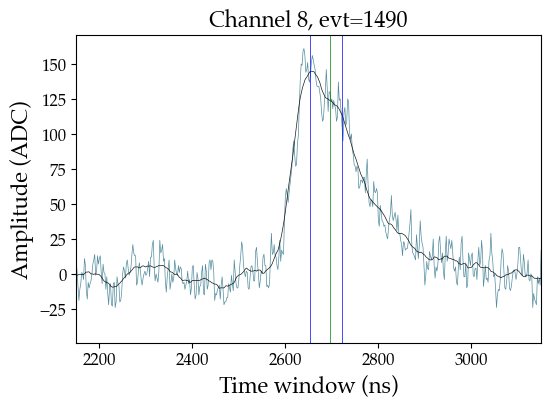

In [221]:
ch = 8

wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=False, wf_range_bsl=(0, 650))
for evt, wf in enumerate(swfs):
    for evt0, peaks10, peaks30, peaks50 in zip(sel_evts, sel_peaks_10, sel_peaks_30, sel_peaks_50):
        if evt0==evt:
            sgwf = pf.savgol_filter(wf, window_length=50, polyorder=3)
            plt.figure(figsize=(6, 4))
            plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color=fav_col, alpha=0.9)
            plt.plot(2*np.arange(len(sgwf)), sgwf, lw=0.5, color='k', alpha=0.9)
            for peak in peaks10:
                if peak not in peaks30 and peak not in peaks50:
                    plt.axvline(2*peak, color='r', lw=0.5)
                elif peak in peaks30 and peak not in peaks50:
                    plt.axvline(2*peak+3, color='g', lw=0.5)
                else:
                    plt.axvline(2*peak+3, color='b', lw=0.5)
            plt.xlabel('Time window (ns)', fontsize=16)
            plt.ylabel('Amplitude (ADC)',  fontsize=16)
            if evt==48:
                plt.xlim(2*peaks10[0]-50, 2*peaks10[0]+2500)
                plt.ylim(-100, 400)
            else:
                plt.xlim(2*peaks10[0]-500, 2*peaks10[0]+500)
            plt.title(f"Channel {ch}, evt={evt}", fontsize=16)
            plt.show()

In [195]:
sel_evts        = []
sel_peaks_50_2  = []
sel_peaks_100_2 = []
for i,(j,k) in enumerate(zip(idx_max_ch8_50['11_25_2024'][:300], idx_max_ch8_100['11_25_2024'])):
    if len(j)!=len(k):
        print(filt_evts_ch8_50['11_25_2024'][i], j, k)
        sel_evts.append(filt_evts_ch8_50['11_25_2024'][i])
        sel_peaks_50_2 .append(j)
        sel_peaks_100_2.append(k)

39 [1779 1817] [1779]
48 [ 747 1003 1030 1155 1204 1279 1344 1499 1624 1879 2807 3007 3764 3956
 4003] [ 747 1003 1155 1279 1344 1499 1624 1879 2807 3007 3764 3956]
98 [41 83] [41]
256 [7433 7479] [7433]
614 [ 749  938  966 1077 1109 1686 2029 2456 2494 3856] [ 749  966 1077 1686 2029 2456 3856]
809 [661 706 818] [661 818]
897 [4424 4459] [4424]
933 [830 863] [830]
959 [3513 3560] [3513]
1032 [6279 6322] [6279]
1053 [6870 6905] [6905]
1125 [3104 3132] [3104]
1135 [7161 7206] [7161]
1160 [4867 4894] [4867]
1229 [4715 4751] [4715]
1298 [5514 5561] [5514]
1325 [316 349] [316]
1387 [1655 1691] [1655]
1461 [5252 5279] [5252]
1490 [1325 1359] [1325]
1608 [1754 1795] [1754]


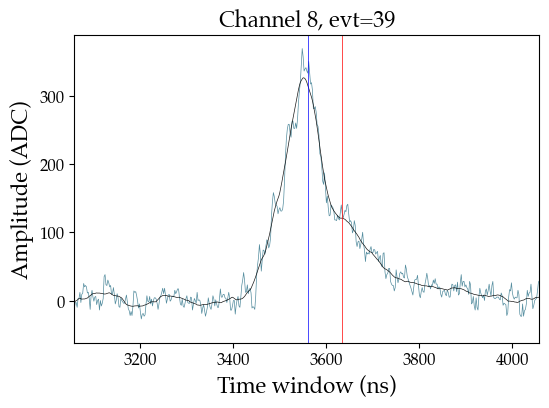

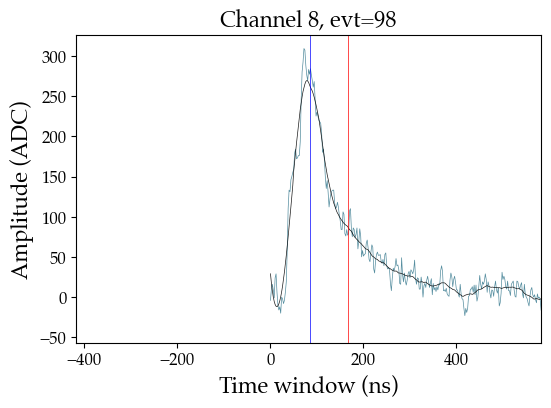

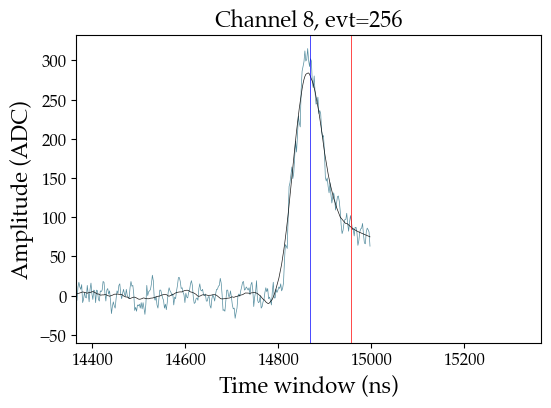

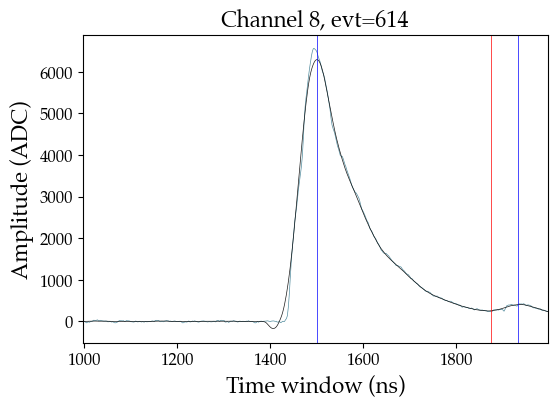

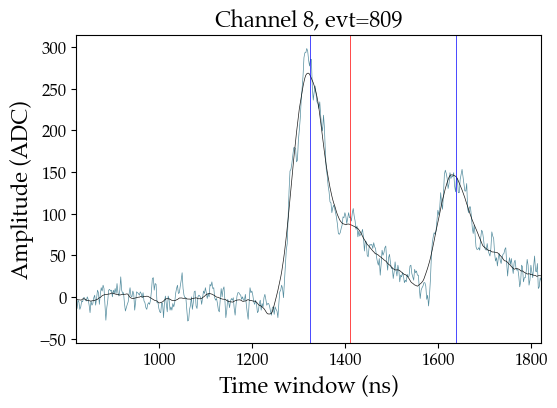

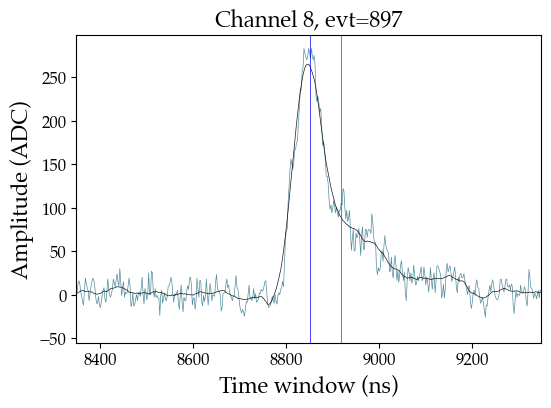

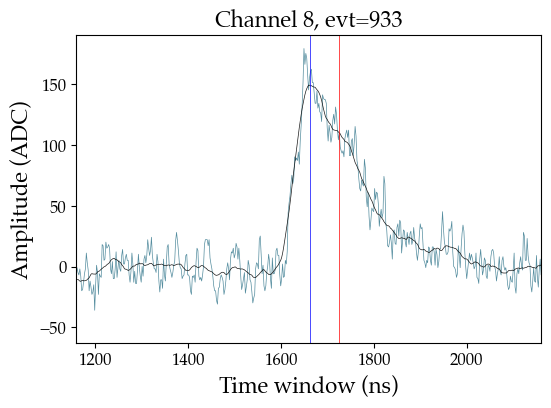

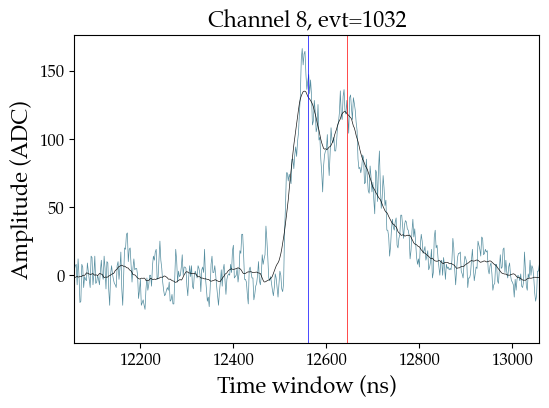

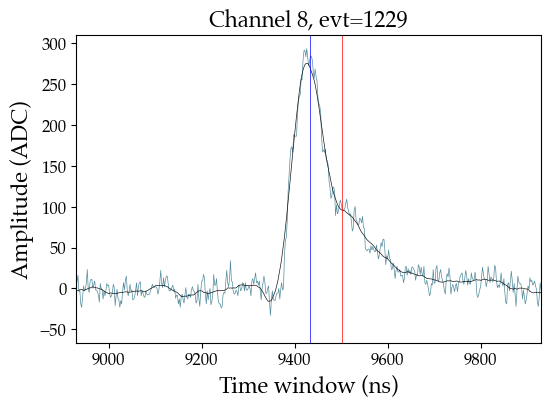

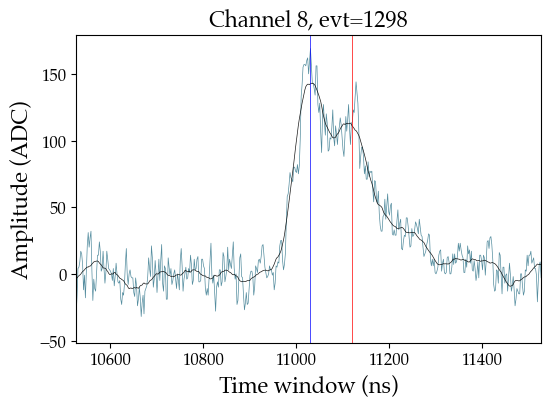

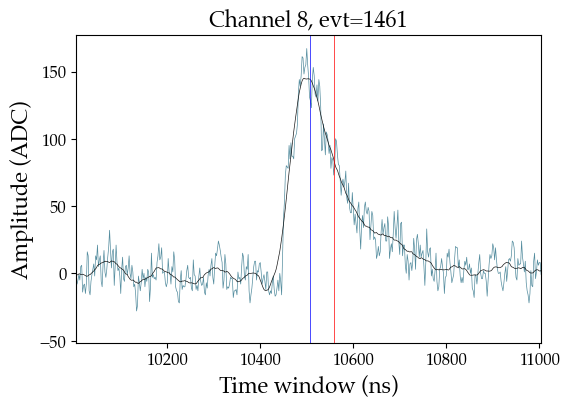

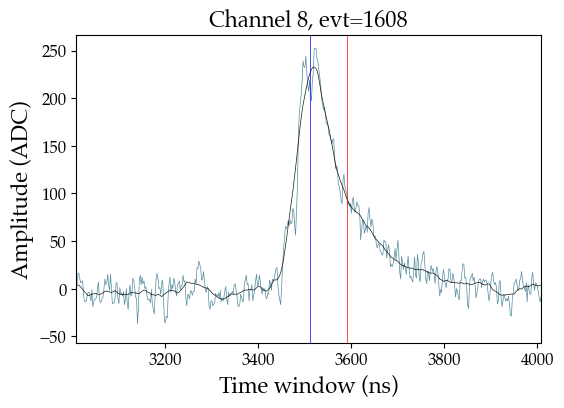

In [199]:
ch = 8

wfs  = np.array(RawTree[f'chan{ch}/rdigi'].array())
swfs = pf.subtract_baseline(wfs, mode=False, wf_range_bsl=(0, 650))
for evt, wf in enumerate(swfs):
    for evt0, peaks50, peaks100 in zip(sel_evts, sel_peaks_50_2, sel_peaks_100_2):
        if evt0==evt:
            sgwf = pf.savgol_filter(wf, window_length=50, polyorder=3)
            plt.figure(figsize=(6, 4))
            plt.plot(2*np.arange(len(wf)), wf, lw=0.5, color=fav_col, alpha=0.9)
            plt.plot(2*np.arange(len(sgwf)), sgwf, lw=0.5, color='k', alpha=0.9)
            for peak in peaks50:
                if peak not in peaks100:
                    plt.axvline(2*peak, color='r', lw=0.5)
                else:
                    plt.axvline(2*peak+3, color='b', lw=0.5)
            plt.xlabel('Time window (ns)', fontsize=16)
            plt.ylabel('Amplitude (ADC)',  fontsize=16)
            plt.xlim(2*peaks50[0]-500, 2*peaks50[0]+500)
            plt.title(f"Channel {ch}, evt={evt}", fontsize=16)
            plt.show()

In [145]:
dist_peaks = []
ampl_peak1 = []
ampl_peak2 = []
for date in idx_max_ch8_10.keys():
    for el1, el2 in zip(idx_max_ch8_10[date], height_sg_ch8_10[date]):
        if len(el1)>1:
            for el3, el4, el5 in zip(np.diff(el1), el2[:-1], el2[1:]):
                dist_peaks.append(el3)
                ampl_peak1.append(el4)
                ampl_peak2.append(el5)

In [170]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

fig0 = axs[0].hist2d(2*np.array(dist_peaks), np.array(ampl_peak1), bins=(100, 100), range=((0, 2000), (80, 300)), cmin=1, norm=LogNorm())
fig1 = axs[1].hist2d(2*np.array(dist_peaks), np.array(ampl_peak2), bins=(100, 100), range=((0, 2000), (80, 300)), cmin=1, norm=LogNorm())

for j, (ax, title, fig00) in enumerate(zip(axs.flatten(), ['Prim peaks', 'Sec peaks'], [fig0, fig1])):
    ax.set_xlabel('Distance between peaks (ns)', fontsize=14)
    ax.set_ylabel('Amplitude peaks (ADC)', fontsize=14)
    ax.set_title(f"{title}", fontsize=15)
    fig.colorbar(fig00[3], ax=ax, pad=0.02)
axs[1].axvline(10)
axs[1].axvline(50)
axs[1].axvline(100)
axs[1].axvline(140, c='r')
axs[1].axhline(140, c='r')

plt.suptitle(f'Channel {ch}, all dates, min_dist = 10 ns')
plt.tight_layout()
plt.show()

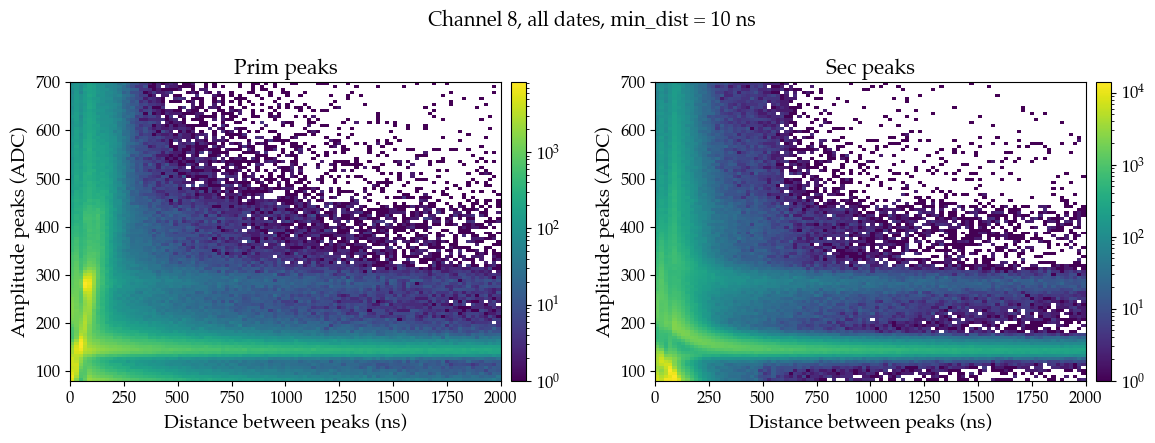

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

fig0 = axs[0].hist2d(2*np.array(dist_peaks), np.array(ampl_peak1), bins=(100, 100), range=((0, 2000), (80, 700)), cmin=1, norm=LogNorm())
fig1 = axs[1].hist2d(2*np.array(dist_peaks), np.array(ampl_peak2), bins=(100, 100), range=((0, 2000), (80, 700)), cmin=1, norm=LogNorm())

for j, (ax, title, fig00) in enumerate(zip(axs.flatten(), ['Prim peaks', 'Sec peaks'], [fig0, fig1])):
    ax.set_xlabel('Distance between peaks (ns)', fontsize=14)
    ax.set_ylabel('Amplitude peaks (ADC)', fontsize=14)
    ax.set_title(f"{title}", fontsize=15)
    fig.colorbar(fig00[3], ax=ax, pad=0.02)

plt.suptitle(f'Channel {ch}, all dates, min_dist = 10 ns')
plt.tight_layout()
plt.show()

In [161]:
dist_peaks_2 = []
ampl_peak1_2 = []
ampl_peak2_2 = []
for date in idx_max_ch8_10.keys():
    for el1, el2 in zip(idx_max_ch8_10[date], height_sg_ch8_10[date]):
        if len(el1)==2:
            for el3, el4, el5 in zip(np.diff(el1), el2[:-1], el2[1:]):
                dist_peaks_2.append(el3)
                ampl_peak1_2.append(el4)
                ampl_peak2_2.append(el5)

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

fig0 = axs[0].hist2d(2*np.array(dist_peaks_2), np.array(ampl_peak1_2), bins=(100, 100), range=((0, 1500), (80, 250)), cmin=1, norm=LogNorm())
fig1 = axs[1].hist2d(2*np.array(dist_peaks_2), np.array(ampl_peak2_2), bins=(100, 100), range=((0, 1500), (80, 250)), cmin=1, norm=LogNorm())

for j, (ax, title, fig00) in enumerate(zip(axs.flatten(), ['Prim peaks', 'Sec peaks'], [fig0, fig1])):
    ax.set_xlabel('Distance between peaks (ns)', fontsize=14)
    ax.set_ylabel('Amplitude peaks (ADC)', fontsize=14)
    ax.set_title(f"{title}", fontsize=15)
    fig.colorbar(fig00[3], ax=ax, pad=0.02)

plt.suptitle(f'Channel {ch}, all dates, min_dist = 10 ns')
plt.tight_layout()
plt.show()

In [154]:
dist_peaks_50ns = []
ampl_peak1_50ns = []
ampl_peak2_50ns = []
for date in idx_max_ch8_50.keys():
    for el1, el2 in zip(idx_max_ch8_50[date], height_sg_ch8_50[date]):
        if len(el1)>1:
            for el3, el4, el5 in zip(np.diff(el1), el2[:-1], el2[1:]):
                dist_peaks_50ns.append(el3)
                ampl_peak1_50ns.append(el4)
                ampl_peak2_50ns.append(el5)

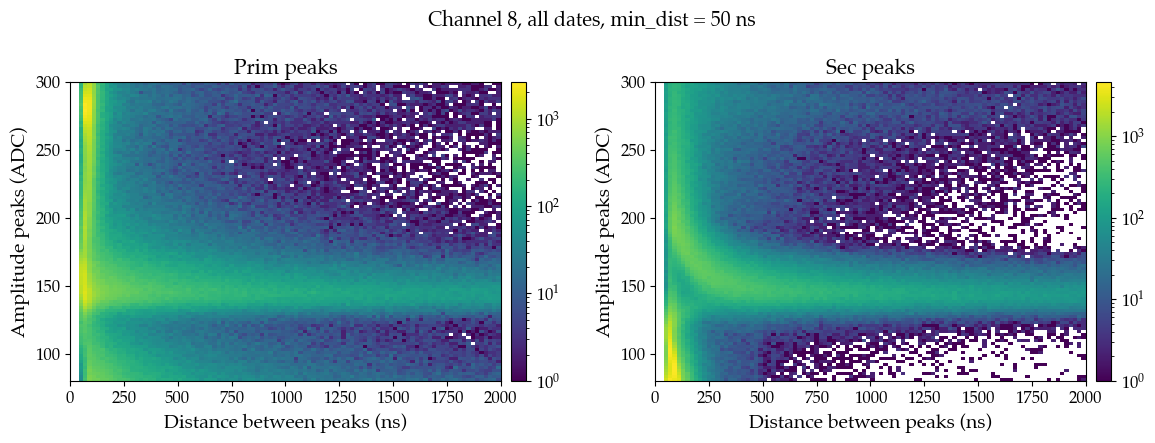

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

fig0 = axs[0].hist2d(2*np.array(dist_peaks_50ns), np.array(ampl_peak1_50ns), bins=(100, 100), range=((0, 2000), (80, 300)), cmin=1, norm=LogNorm())
fig1 = axs[1].hist2d(2*np.array(dist_peaks_50ns), np.array(ampl_peak2_50ns), bins=(100, 100), range=((0, 2000), (80, 300)), cmin=1, norm=LogNorm())

for j, (ax, title, fig00) in enumerate(zip(axs.flatten(), ['Prim peaks', 'Sec peaks'], [fig0, fig1])):
    ax.set_xlabel('Distance between peaks (ns)', fontsize=14)
    ax.set_ylabel('Amplitude peaks (ADC)', fontsize=14)
    ax.set_title(f"{title}", fontsize=15)
    fig.colorbar(fig00[3], ax=ax, pad=0.02)

plt.suptitle(f'Channel {ch}, all dates, min_dist = 50 ns')
plt.tight_layout()
plt.show()

In [158]:
dist_peaks_100ns = []
ampl_peak1_100ns = []
ampl_peak2_100ns = []
for date in idx_max_ch8_100.keys():
    for el1, el2 in zip(idx_max_ch8_100[date], height_sg_ch8_100[date]):
        if len(el1)>1:
            for el3, el4, el5 in zip(np.diff(el1), el2[:-1], el2[1:]):
                dist_peaks_100ns.append(el3)
                ampl_peak1_100ns.append(el4)
                ampl_peak2_100ns.append(el5)

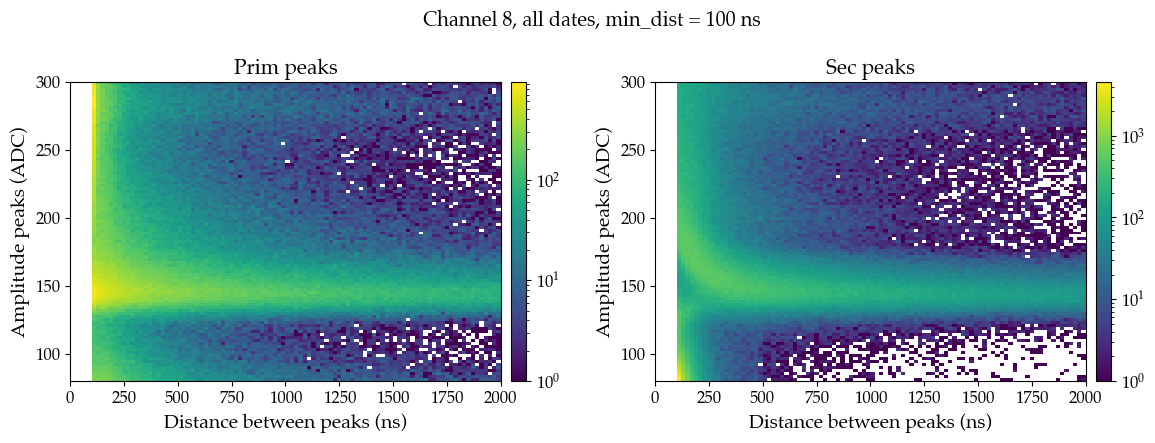

In [159]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

fig0 = axs[0].hist2d(2*np.array(dist_peaks_100ns), np.array(ampl_peak1_100ns), bins=(100, 100), range=((0, 2000), (80, 300)), cmin=1, norm=LogNorm())
fig1 = axs[1].hist2d(2*np.array(dist_peaks_100ns), np.array(ampl_peak2_100ns), bins=(100, 100), range=((0, 2000), (80, 300)), cmin=1, norm=LogNorm())

for j, (ax, title, fig00) in enumerate(zip(axs.flatten(), ['Prim peaks', 'Sec peaks'], [fig0, fig1])):
    ax.set_xlabel('Distance between peaks (ns)', fontsize=14)
    ax.set_ylabel('Amplitude peaks (ADC)', fontsize=14)
    ax.set_title(f"{title}", fontsize=15)
    fig.colorbar(fig00[3], ax=ax, pad=0.02)

plt.suptitle(f'Channel {ch}, all dates, min_dist = 100 ns')
plt.tight_layout()
plt.show()